In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

In [3]:
from latent_rnn import create_LatentODE_model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading

In [5]:
obsrv_std = torch.Tensor([0.01]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
input_dim = 1
model = create_LatentODE_model(input_dim, z0_prior, obsrv_std)

In [6]:
# state = torch.load('latent_ode_state.pth.tar')
state = torch.load('latent_ode_state.pth.tar', map_location=torch.device('cpu'))

In [7]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [8]:
model.eval()

LatentODE(
  (encoder_z0): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=102, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=50, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=102, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=50, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=102, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=50, out_features=100, bias=True)
          (1): Tanh()
          (2): Linear(in_features=100, out_features=100, bias=True)
          (3): Tanh()
          (4): 

In [178]:
loader = torch.load('vae_cv_loader.pt')

## Inference

In [179]:
z_us = []
z_stds = []
truths = []
ts = []
recs = []
for batch in tqdm(loader):
    observed = batch['observed_data']
    true = batch['data_to_predict']
    truths.append(true)
    mask = batch['observed_mask']
    mask_pred = batch['mask_predicted_data']
    mask_pred = torch.ones(mask.shape)
    x = torch.cat((observed, mask), -1)
    x2 = torch.cat((true, mask_pred), -1)
    t = batch['observed_tp']
    ts.append(t)
    z_u, z_std = model.encoder_z0.forward(x, t)
    rec = model.get_reconstruction(time_steps_to_predict=t, truth=x, truth_time_steps=t)
    recs.append(rec)
#     z_u = z_u.squeeze()
#     z_u = z_u.detach().cpu().numpy()
    z_us.append(z_u)
    z_stds.append(z_std)

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


In [180]:
z_us = torch.cat(z_us,1).squeeze()
z_stds = torch.cat(z_stds,1).squeeze()
truths = torch.cat(truths,0).squeeze()

In [181]:
truths.shape

torch.Size([50, 128])

In [182]:
recs = [x[:][0] for x in recs]
recs = torch.cat(recs,1)
recs = recs.squeeze()

In [183]:
recs.shape

torch.Size([50, 128])

In [184]:
z_us.shape

torch.Size([50, 30])

In [185]:
ix = 1

In [186]:
u = z_us[ix]
std = z_stds[ix]

In [187]:
def sample(z, t):
    sol_y = model.diffeq_solver.sample_traj_from_prior(z, t, n_traj_samples = 10)
    out = model.decoder(sol_y)
    return out

In [188]:
t=ts[0]

In [189]:
u.unsqueeze(0).shape

torch.Size([1, 30])

In [190]:
out = sample(u.unsqueeze(0).unsqueeze(0), t)

In [191]:
out = out.squeeze()

In [192]:
out.shape

torch.Size([128])

In [193]:
out.min()

tensor(-1.6106, grad_fn=<MinBackward1>)

In [194]:
t = t.detach().cpu().numpy()
out = out.detach().cpu().numpy()

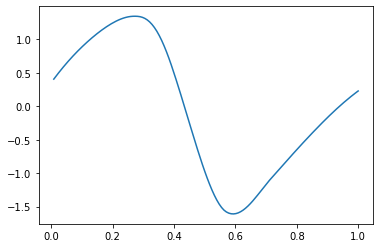

In [195]:
sns.lineplot(x=t, y=out)

In [201]:
ix=10

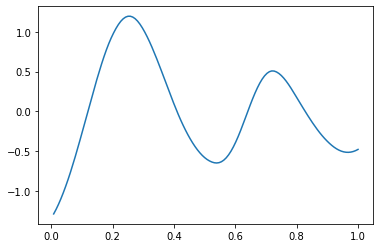

In [202]:
sns.lineplot(x=t, y=recs[ix].detach().cpu().numpy())

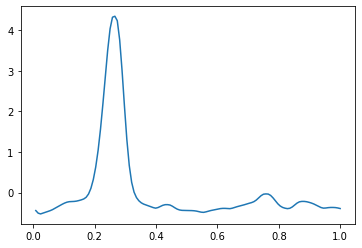

In [203]:
sns.lineplot(x=t, y=truths[ix].squeeze().detach().cpu().numpy())

In [153]:
truths.mean()

tensor(0.0334)

### TSNE

In [141]:
from sklearn.manifold import TSNE

In [142]:
z_us.shape

torch.Size([450, 30])

In [143]:
latents = z_us.squeeze().detach().cpu().numpy()

In [144]:
latents.shape

(450, 30)

In [145]:
tsne = TSNE(perplexity=10)

In [146]:
xx = tsne.fit_transform(latents)

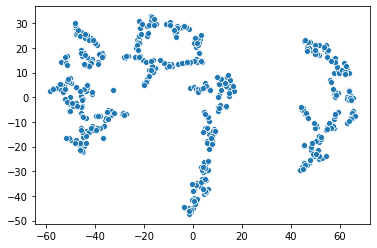

In [147]:
sns.scatterplot(x=xx[:,0], y=xx[:,1])

In [161]:
df = pd.DataFrame(xx, columns=['x1','x2'])
df['minimums'] = [np.round(x.min().item(),2) for x in truths]

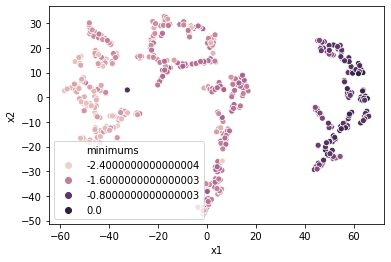

In [162]:
sns.scatterplot(x='x1', y='x2', data=df, hue='minimums')

In [163]:
g=df.loc[(df['x1']<-40) & (df['x2']<-30)]
# g=df.loc[(df['x1']>0) & (df['x2']>100)]

In [164]:
gx = g.index

In [165]:
len(truths)

450

In [166]:
ls=truths[gx]

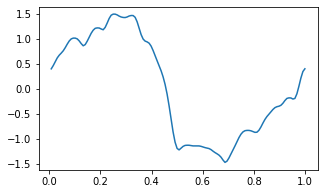

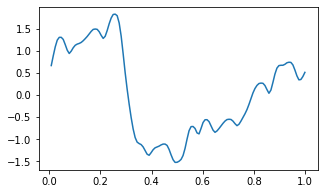

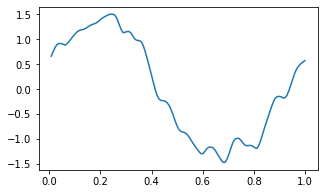

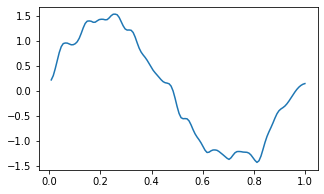

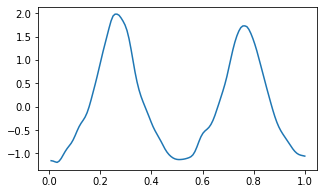

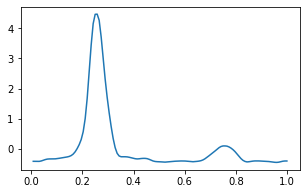

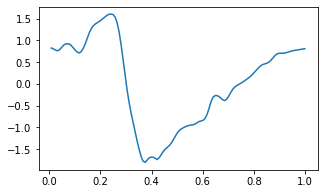

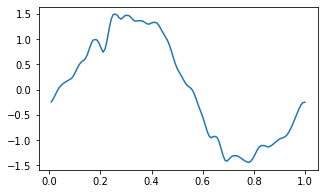

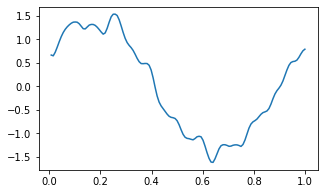

IndexError: list index out of range

<Figure size 360x216 with 0 Axes>

In [167]:
for i, p in enumerate(truths):
    x = p.detach().cpu().squeeze().numpy()
    plt.figure(figsize=(5,3))
    sns.lineplot(x=ts[i], y=x)
    plt.show()